Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
all_df = pd.read_csv("../raw_data/master_indicators_to_equity_20210628.csv")
all_df.head()
poll = all_df[['PM25', 'OZONE', 'DSLPM', 'RESP', 'PTRAF', 'GEOID']]
poll_ptile = all_df[['ptile_PM25', 'ptile_OZONE', 'ptile_DSLPM', 'ptile_RESP', 'ptile_PTRAF']]
original_air_quality_indicator = all_df[['poll_ptile']]

As shown in the pairwise scatter plot and correlation matrix below, we see that the percentiles of PM2.5 and OZONE are highly linearly correlated. 

             ptile_PM25  ptile_OZONE  ptile_DSLPM  ptile_RESP  ptile_PTRAF
ptile_PM25     1.000000     0.975101     0.548053    0.519748     0.174203
ptile_OZONE    0.975101     1.000000     0.575535    0.552777     0.215932
ptile_DSLPM    0.548053     0.575535     1.000000    0.953430     0.435794
ptile_RESP     0.519748     0.552777     0.953430    1.000000     0.416149
ptile_PTRAF    0.174203     0.215932     0.435794    0.416149     1.000000


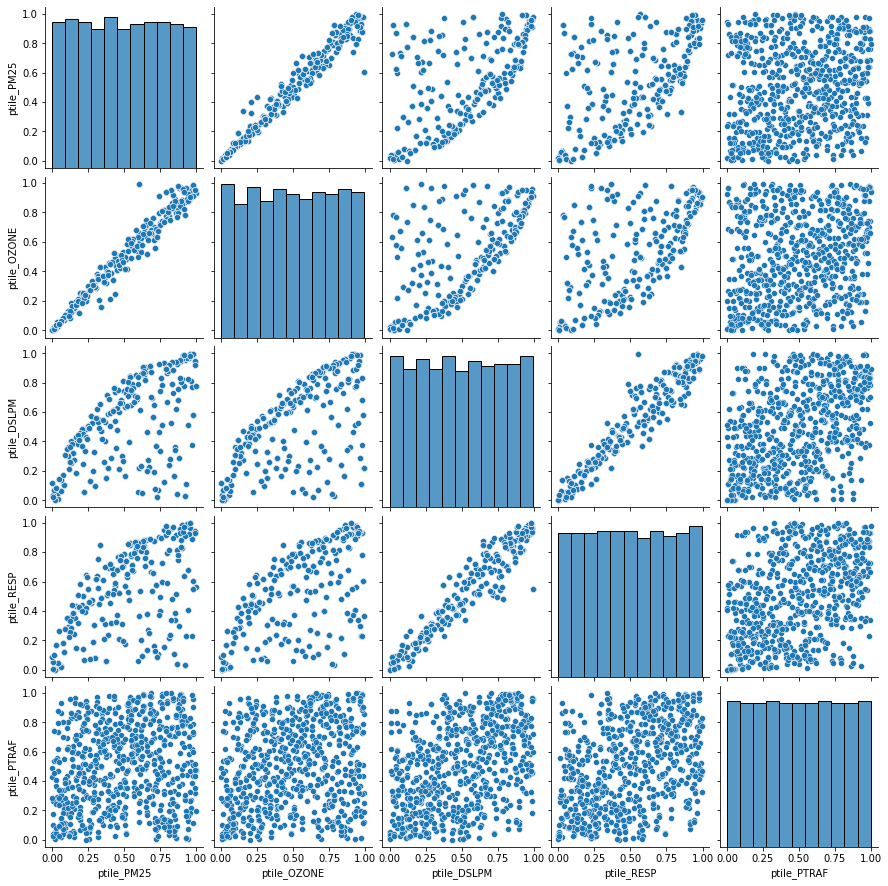

In [2]:
sns.pairplot(poll_ptile)
print(poll_ptile.corr())

In [3]:
def scale_based_on_percentile(x):
    scale = 0
    if x > 0.25:
        scale = scale + 1
    if x > 0.5:
        scale = scale + 1
    if x > 0.75:
        scale = scale + 1
    return scale

original_air_quality_indicator['scales'] = original_air_quality_indicator['poll_ptile'].apply(scale_based_on_percentile)

original_air_quality_indicator.head()

<ipython-input-3-75913334ab4b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_air_quality_indicator['scales'] = original_air_quality_indicator['poll_ptile'].apply(scale_based_on_percentile)


poll_ptile  scales
0    0.842025       3
1    0.857362       3
2    0.911043       3
3    0.897239       3
4    0.941718       3

We normalise all variables so they have mean 0.

In [4]:
import plotly.express as px
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()

scaled = scaler.fit_transform(poll)

scaled_df = pd.DataFrame(scaled, columns = poll.columns)

/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In the plots we see below, we find that the original 4 scales in the report fails to distinguish groups with **significantly different traffic proximity**. The reason is likely that because of the strong correlation among variables taken into account in the original scoring system, the effect of traffic proximity on the final score gets very diluted.

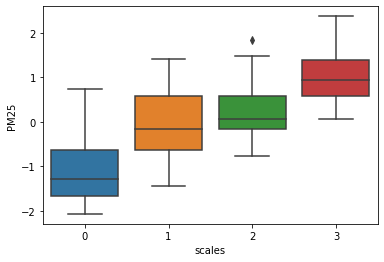

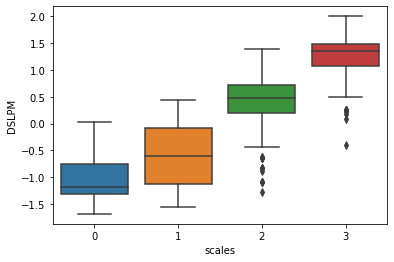

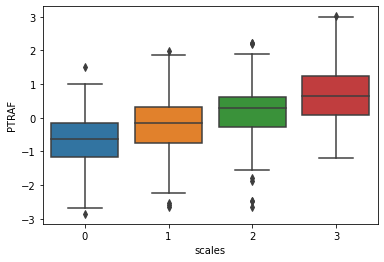

In [5]:
scaled_df['scales'] = original_air_quality_indicator['scales']
for col in ['PM25', 'DSLPM', 'PTRAF']:
    sns.boxplot(x='scales', y=col, data=scaled_df)
    plt.show()
    
import plotly.express as px
fig = px.scatter_3d(
    np.array(scaled_df[['PM25', 'DSLPM', 'PTRAF']]), x=0, y=1, z=2, 
    color=scaled_df['scales']
)
fig.show()

As an alternative, we recommend removing highly correlated variables. Moreover, we have seen that census blocks with very high PM2.5 pollution does not necessarily have high level of pollution in diesel or high proximity to traffic. Thus, we believe any easily calculatable score could fail to capture this heterogeneity within the data. Thus, we propose a more data-driven approach to identify different pollution problems across the city.

As a first step, we propose clustering to group together census blocks with similar levels of pollution. We use cosine metric to measure the similarity between two vectors. Silhouette score is a popular measure for the quality of clustering.

In [6]:
import umap
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
metric = 'cosine'

umap_df = umap.UMAP(n_neighbors=10, n_components=3, metric=metric,
                    random_state=42).fit_transform(scaled_df[['PM25', 'DSLPM', 'PTRAF']])
cluster_labels = {}

score_metric = 'cosine'

for n_clusters in range(2, 10):
    cluster = SpectralClustering(n_clusters=n_clusters)
    cluster.fit(umap_df)
    cluster_labels[n_clusters] = cluster.labels_
    orig_score = silhouette_score(scaled_df[['PM25', 'DSLPM', 'PTRAF']], cluster_labels[n_clusters], metric=score_metric)
    umap_score = silhouette_score(umap_df, cluster_labels[n_clusters], metric=score_metric)
    print(f'Spectral {n_clusters}-clusters, original score: {orig_score}, umap score: {umap_score}')

Spectral 2-clusters, original score: 0.3068544549021164, umap score: 0.5107346773147583
Spectral 3-clusters, original score: 0.21401756923869858, umap score: 0.3015546500682831
Spectral 4-clusters, original score: -0.10134972376208529, umap score: 0.043942730873823166
Spectral 5-clusters, original score: -0.09941548504333036, umap score: 0.13849526643753052
Spectral 6-clusters, original score: 0.1296820804903999, umap score: 0.4632127583026886
Spectral 7-clusters, original score: 0.237582931195252, umap score: 0.5398935079574585
Spectral 8-clusters, original score: 0.19713199031933565, umap score: 0.4428643584251404
Spectral 9-clusters, original score: 0.2864229911407834, umap score: 0.527353823184967


In [7]:
n_clusters = 9

import plotly.express as px

cmap = sns.color_palette("Paired", as_cmap=True)

fig = px.scatter_3d(
    np.array(scaled_df[['PM25', 'DSLPM', 'PTRAF']]), x=0, y=1, z=2, color = pd.Series(cluster_labels[n_clusters],
                                                                                     )
)
fig.show()

In [8]:
import geopandas

path_to_data = "../shape_files/block_groups.geojson"
gdf = geopandas.read_file(path_to_data)

scaled_df['cluster'] = cluster_labels[n_clusters]

poll = poll.astype({'GEOID': str})

scaled_df['GEOID'] = poll['GEOID']

gdf = pd.merge(gdf, scaled_df, on="GEOID")

In [9]:
gdf.explore("cluster", cmap = 'Set1')

We see that each group has different levels of pollution: for example, group 1 (blue) seems to have high concentration of all pollutant, while group 4 (orange) does have high concentration on pollutants but low proximity to traffic. This is yet far from perfect, but we hope that this serves as a good starting point.

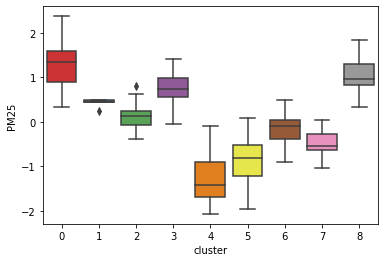

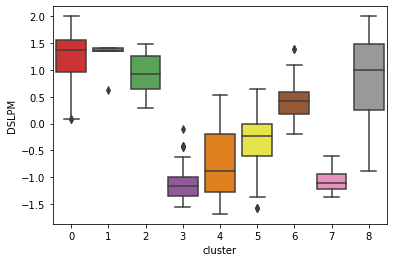

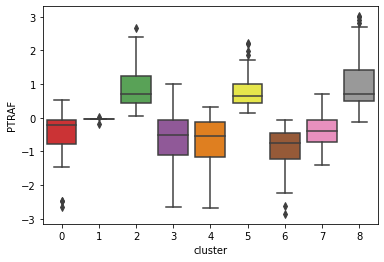

In [10]:
for col in ['PM25', 'DSLPM', 'PTRAF']:
    sns.boxplot(x='cluster', y=col, data=scaled_df, palette='Set1')
    plt.show()